In [2]:
import sys, os

import tensorflow as tf
import numpy as np
import json
from PIL import Image
import glob

import matplotlib.pyplot as plt

In [3]:
# filepath = "C:/Users/user/Downloads/crack_100.json"
filepath = "D:/_김정원/ss_class(AI)/Surface_Crack_Segmentation/crack_100.json"
with open(filepath) as json_file:
    json_data = json.load(json_file)

In [4]:
data_names = list(json_data.keys())
file_names = [file_name[:-4] for file_name in data_names]

In [5]:
## data_name과 file_name 차이를 보려면, 아래 주석을 해제하세요
# print(data_names)
# print(file_names)

# 첫 번째 이미지로 마스킹을 확인해보자

In [6]:
def draw_rect_box(x_pos,y_pos,width,height):
    ###현재의 plt에 사각형 박스를 그려주는 함수입니다.
    ###
    x_ = [x_pos, x_pos+width, x_pos+width, x_pos, x_pos]
    y_ = [y_pos, y_pos, y_pos + height, y_pos + height, y_pos]
    
    plt.plot(x_,y_,'red')

In [7]:
_,x_pos,y_pos,width,height = json_data['00001.jpg5217']['regions'][0]['shape_attributes'].values()
# print(type(json_data['00001.jpg5217']['regions'][0]))
print("x_pos: {}, y_pos: {}, width: {}, height: {}".format(x_pos,y_pos,width,height))

x_pos: 62, y_pos: 3, width: 99, height: 222


image shape is : (227, 227, 3)


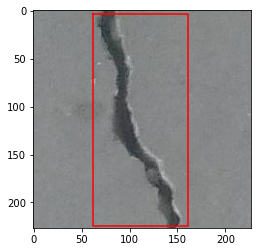

In [9]:
# img_path = 'D:/_김정원/archive/Positive_jw/'
img_path = "D:/_김정원/ss_class(AI)/Surface_Crack_Segmentation/Positive_jw/"
img_name = '00001.jpg'
# img_name = '00002.jpg'

# img_full_path = os.path.join(img_path,img_name)
img_full_path = img_path + img_name
img_arr = np.array(Image.open(img_full_path))

print("image shape is :",img_arr.shape)
WIDTH,HEIGHT,CHANNEL = img_arr.shape # 이미지의 너비, 높이, 채널을 저장

plt.imshow(img_arr)
draw_rect_box(x_pos,y_pos,width,height)

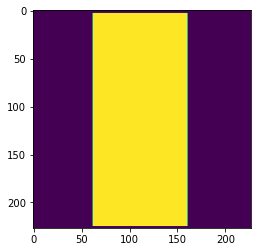

In [10]:
# 데이터셋에서 label의 형태는 binary image 이므로, 같은 형태로 바꾸어 준다.
def make_to_label_img(x_pos,y_pos,width,height,WIDTH=227,HEIGHT=227):
    label_sample = np.zeros((WIDTH,HEIGHT))
#     print(label_sample.shape)

    for i in range(WIDTH):
        for j in range(HEIGHT):
            if i >= x_pos and i<x_pos+width:
                if j>=y_pos and j < y_pos+height:
                    label_sample[j][i] = 1
    return label_sample
#     plt.imshow(label_sample)

label_sample = make_to_label_img(x_pos,y_pos,width,height)
plt.imshow(label_sample)

# 데이터셋을 생성

## 크랙이 있는 데이터부터 로드

In [11]:
_,x_pos,y_pos,width,height = json_data['00001.jpg5217']['regions'][0]['shape_attributes'].values()

y_train_positive = []
for i in range(len(data_names)):
    _,x_pos,y_pos,width,height = json_data[data_names[i]]['regions'][0]['shape_attributes'].values()
    label_tmp = make_to_label_img(x_pos,y_pos,width,height)
#     print(i)
    y_train_positive.append(label_tmp)

In [12]:
y_train_positive = np.array(y_train_positive)
# y_train_positive = y_train_positive.reshape(y_train_positive.shape[0],y_train_positive.shape[1],y_train_positive.shape[2],1)
# print(y_train_positive.shape)

# (227,227)이미지는 Conv에 적합하지 않으므로, (128,128)로 resize합니다
y_train_positive_resized=[]
for i in y_train_positive:
    Im = Image.fromarray(i)
    Im = Im.resize((128,128),Image.BOX)
    y_train_positive_resized.append(np.ceil(np.array(Im)))
y_train_positive = np.array(y_train_positive_resized)
y_train_positive = y_train_positive.reshape(y_train_positive.shape[0],y_train_positive.shape[1],y_train_positive.shape[2],1)

In [11]:
print(np.max(y_train_positive))
print("y_train_positive shape :",y_train_positive.shape)

1.0
y_train_positive shape : (100, 128, 128, 1)


In [12]:
positive_path = 'D:/_김정원/archive/Positive_jw/*.jpg'
negative_path = 'D:/_김정원/archive/Negative_jw/*.jpg'
positive_imgs = glob.glob(positive_path)
negative_imgs = glob.glob(negative_path)

x_train_positive = []
for i in range(len(positive_imgs)):
    Im = Image.open(positive_imgs[i])
    Im = Im.resize((128,128))
    x_train_positive.append(np.array(Im))
x_train_positive = np.array(x_train_positive)

x_train_negative = []
for i in range(len(negative_imgs)):
    Im = Image.open(negative_imgs[i])
    Im = Im.resize((128,128))
    x_train_negative.append(np.array(Im))
x_train_negative = np.array(x_train_negative)

print("x_train_positive shape :",x_train_positive.shape)
print("x_train_negative shape :",x_train_negative.shape)

x_train_positive shape : (100, 128, 128, 3)
x_train_negative shape : (100, 128, 128, 3)


In [13]:
# 크랙이 있는 것과 없는 것 두가지를 concat해서 x_train 데이터를 만든다.
x_train = np.concatenate((x_train_negative,x_train_positive))
x_train = x_train/255.0
print("x_train shape :",x_train.shape)

x_train shape : (200, 128, 128, 3)


In [14]:
# negative 데이터의 label은 모두 0일 것이다 <-- 크랙이 없기 때문에
y_train_negative = np.zeros((x_train_negative.shape[0], 128, 128, 1))
# print(y_train_negative.shape)

# label(y_train)도 concat해준다
y_train = np.concatenate((y_train_negative,y_train_positive))
print(y_train.shape)

(200, 128, 128, 1)


In [15]:
BATCH_SIZE=10
dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(10000).batch(BATCH_SIZE)

# 모델 정의하기 (Simple U-Net)

In [16]:
OUTPUT_CHANNELS = 3

# 베이스모델로 MobileNetV2를 사용해서, 조금 더 가벼운 네트워크를 구성하고자 합니다.
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, CHANNEL], include_top=False)
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [17]:
# U-Net에서 특징 추출 레이어로 사용할 계층들입니다.
#이 층들의 활성화를 이용합시다
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

layers = [base_model.get_layer(name).output for name in layer_names]

# U-Net은 다음과 같은 구조로, 일부는 정확한 지역화(Localization)을 수행하게 됩니다.
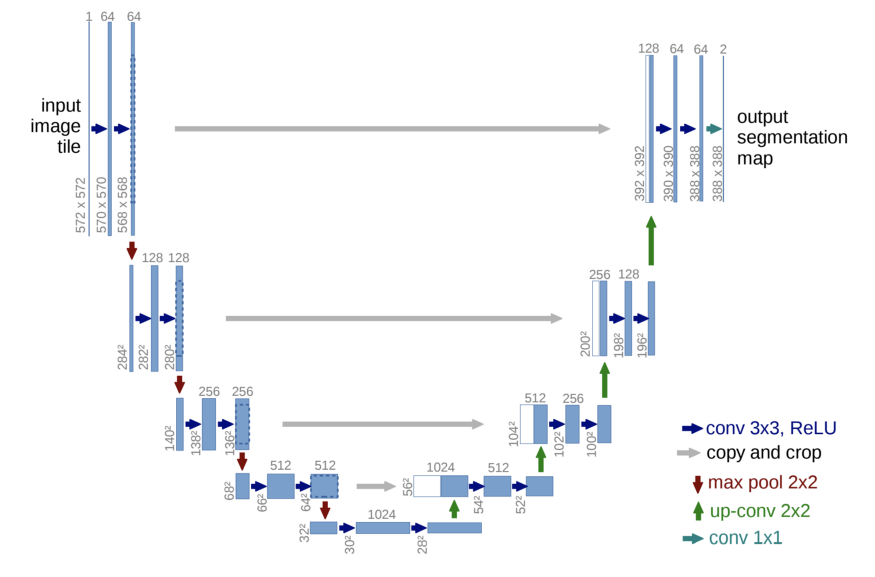

In [18]:
# U-net은 기본적으로 아래층으로 심층 특징 추출하는 층과, skip하는 층이 합쳐지는 구조# 특징추출 모델을 만듭시다.
# 이를 'down_stack'한다고 합니다.
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

# 이미 특징 추출은 MobileNet에서 수행되었기 때문에, trainable = False
down_stack.trainable = False

In [19]:
# up_stack을 1회 수행하는 하나의 계층을 만들도록 upsample 함수를 정의합니다.
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,padding='same',kernel_initializer=initializer,use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [20]:
up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [21]:
def build_model(num_output_channels):
    input_layer = tf.keras.layers.Input(shape=[128,128,3])
    x = input_layer
    
#     모델을 다운 스택
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])
    
#     skip connection을 upsampling한다
    for up, skip in zip(up_stack,skips):
        x = up(x)
        #  skip해서 넘어오는 connection과 down_stack에서 올라오는 up을 concatenate한다.
        concat = tf.keras.layers.Concatenate()
        x = concat([x,skip])
        
    # 현재 최종 계층의 output shape = (None, 64,64,1)
    # 마지막 계층으로 Conv2DTranspose를 함으로써, output shape를 (None, 64, 64, Channel)로 지정한다
    last_layer = tf.keras.layers.Conv2DTranspose(num_output_channels, 3, strides=2, padding='same') # 64x64 -> 128,128
    
    x = last_layer(x)
    
    return tf.keras.Model(inputs=input_layer, outputs=x)

In [22]:
OUTPUT_CHANNELS = 3
model = build_model(OUTPUT_CHANNELS)

model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

# 모델의 그래프를 출력

In [23]:
colab = False
if colab:
    from tensorflow.keras.utils import plot_model
    plot_model(model, show_shapes=True)
else:
     model.summary()   

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 64, 64, 96), 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 512)    1476608     model[0][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 1088)   0           sequential[0][0]                 
                                                                 model[0][3]                

# 초기 prediction을 출력

In [24]:
# image, mask = next(iter(dataset))
# predicted_mask = model.predict(image)

# # output 3채널 중에서 가장 큰 값들을 찾아서 1채널로 축소
# predicted_mask = tf.argmax(predicted_mask, axis=-1)
# predicted_mask = np.array(predicted_mask).reshape((10,128,128,1))

In [25]:
# # 의미없는 Mask들이 나오는 것을 볼 수 있다.
# plt.figure(figsize=(15,20))
# for i in range(10):
#     plt.subplot(1,10,i+1)
#     plt.imshow(predicted_mask[i].reshape(128,128,1))

In [26]:
sample_image, sample_mask = next(iter(dataset))

In [27]:
def show_predictions(dataset=None, num=1,epoch=None):
  if dataset:
    for image, mask in dataset.take(num):
      predicted_mask = model.predict(image)
      # output 3채널 중에서 가장 큰 값들을 찾아서 1채널로 축소
      predicted_mask = tf.argmax(predicted_mask, axis=-1)
      predicted_mask = np.array(predicted_mask).reshape((10,128,128,1))
#       display([image[0], mask[0], predicted_mask])
      
      plt.figure(figsize=(15,5))
      for i in range(BATCH_SIZE):
        plt.subplot(3,BATCH_SIZE,i+1)
        plt.imshow(image[i])
        plt.subplot(3,BATCH_SIZE,i+BATCH_SIZE+1)
        plt.imshow(np.array(mask[i]).reshape(128,128))
        plt.subplot(3,BATCH_SIZE,i+2 * BATCH_SIZE+1)
        plt.imshow(predicted_mask[i].reshape(128,128,1))
  else:
    predicted_mask = model.predict(sample_image)
    predicted_mask = tf.argmax(predicted_mask, axis=-1)
    predicted_mask = np.array(predicted_mask).reshape((10,128,128,1))
    plt.figure(figsize=(15,5))
    for i in range(BATCH_SIZE):
      plt.subplot(3,BATCH_SIZE,i+1)
      plt.imshow(sample_image[i])
      plt.subplot(3,BATCH_SIZE,i+BATCH_SIZE+1)
      plt.imshow(np.array(sample_mask[i]).reshape(128,128))
      plt.subplot(3,BATCH_SIZE,i+2 * BATCH_SIZE+1)
      plt.imshow(predicted_mask[i].reshape(128,128,1))
#     plt.show()
    if epoch:
        save_path = "C:/Users/user/Desktop/_MINI_PROJECT/fig_saves/"
        file_name = "{}.png".format(epoch)
        plt.savefig(save_path+file_name)
    plt.show()

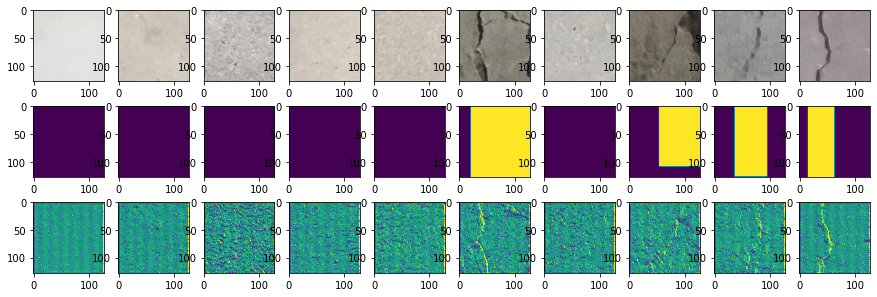

In [28]:
# 다소 약한 Mask들이 나오는 것을 볼 수 있다.
show_predictions(dataset,1)

In [29]:
# 각 트레인 epoch가 끝날 때마다 트레이닝 sample_image, sample_mask로부터 학습과정을 시각화합니다.
from IPython.display import clear_output
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions(epoch = epoch)
#     print ('\n에포크 이후 예측 예시 {}\n'.format(epoch+1))

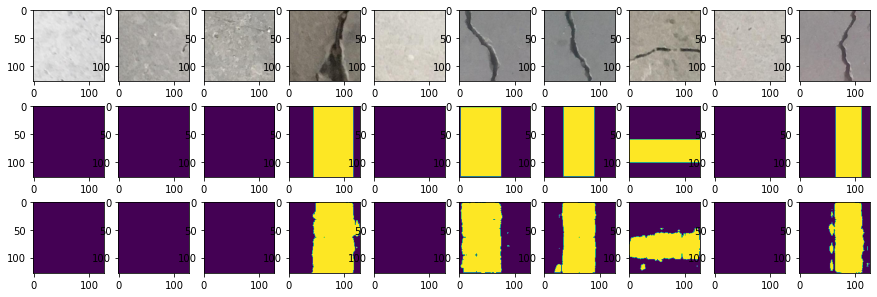

In [30]:
EPOCHS = 50
# VAL_SUBSPLITS = 1
# VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = x_train.shape[0]/BATCH_SIZE

model_history = model.fit(dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          callbacks=[DisplayCallback()])

In [31]:
model.save("C:/Users/user/Desktop/_MINI_PROJECT/MY_MODEL")

INFO:tensorflow:Assets written to: C:/Users/user/Desktop/_MINI_PROJECT/MY_MODEL\assets


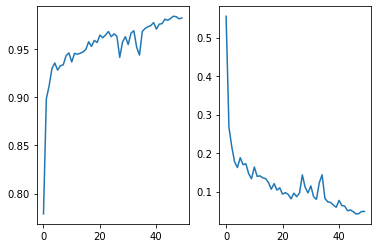

In [38]:
plt.subplot(1,2,1)
plt.plot(model_history.history['accuracy'])
plt.title = "accuracy"
plt.subplot(1,2,2)
plt.plot(model_history.history['loss'])
plt.title = "loss"